# HW1: Electrical Consumption by Weather

**Dataset:** elec_weather.csv

**Name:** Eric Liu

**Resources Consulted:** Regression Case Study: Student Performance

note: discussion question answers at bottom of notebook

In [1]:
# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


# Loading Dataset

This section loads the given dataset into a pandas DataFrame, and lists out the characteristics of the data, including the key metrics and missing data.

In [12]:
DATA_PATH = "elec_weather.csv"
df = pd.read_csv(DATA_PATH)
df = df.set_index("date") #index line to remove date from relevant data while preserving index
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())
print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())


Shape: (1433, 5)

Columns:
['AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']


,AWND,PRCP,TMAX,TMIN,daily_consumption
date,,,,,
2006-12-16,2.5,0.0,10.6,5.0,1209.176
2006-12-17,2.6,0.0,13.3,5.6,3390.460
2006-12-18,2.4,0.0,15.0,6.7,2203.826
2006-12-19,2.4,0.0,7.2,2.2,1666.194
2006-12-20,2.4,0.0,7.2,1.1,2225.748



Summary statistics:


,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
mean,2.642313,3.800488,17.187509,9.141242,1561.078061
std,1.140021,10.973436,10.136415,9.028417,606.819667
min,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,3.300000,1.300000,26.100000,17.200000,1893.608000
max,10.200000,192.300000,39.400000,27.200000,4773.386000



Missing values per column:


AWND                 15
PRCP                  0
TMAX                  0
TMIN                  0
daily_consumption     0
dtype: int64

# Utility Functions

Functions to prepare data and run model. Functions are reused from the Regression Case Study demo.

In [13]:
TARGET_COL = "daily_consumption"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)


# Execution

Runs models and displays resultant actual vs. predicted results for each regression degree, and displays a table showing test and train metrics.


Scenario: Electric Consumption vs. Weather
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2045.7562 (-17.2734) * TMAX (-17.0839) * TMIN (-7.5783) * AWND (-3.3603) * PRCP


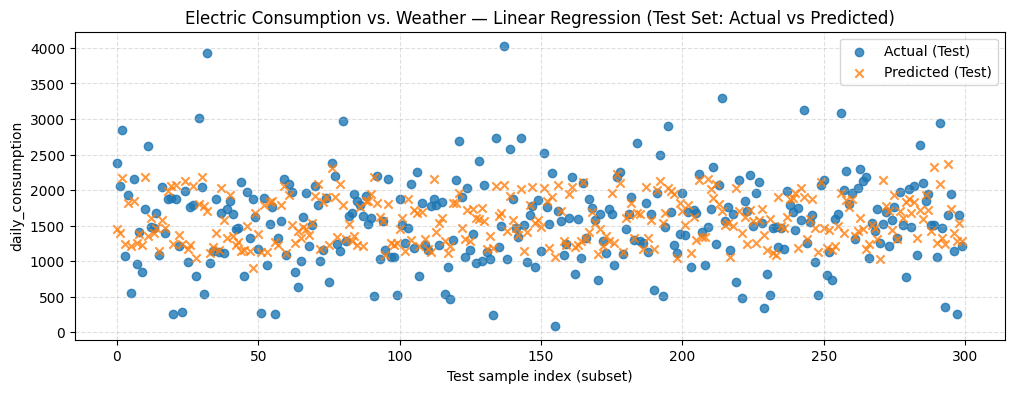


Scenario: Electric Consumption vs. Weather
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2037.4142 (+165.5267) * AWND (-60.9740) * TMAX (-27.8962) * AWND^2 (+26.8325) * TMIN (-10.4820) * PRCP (-2.6130) * TMAX TMIN (-1.9368) * PRCP TMIN (+1.8505) * TMAX^2 (+1.5725) * PRCP TMAX (+1.2309) * AWND PRCP (+1.1693) * AWND TMIN (-1.0760) * AWND TMAX (+0.2939) * TMIN^2 (-0.0545) * PRCP^2


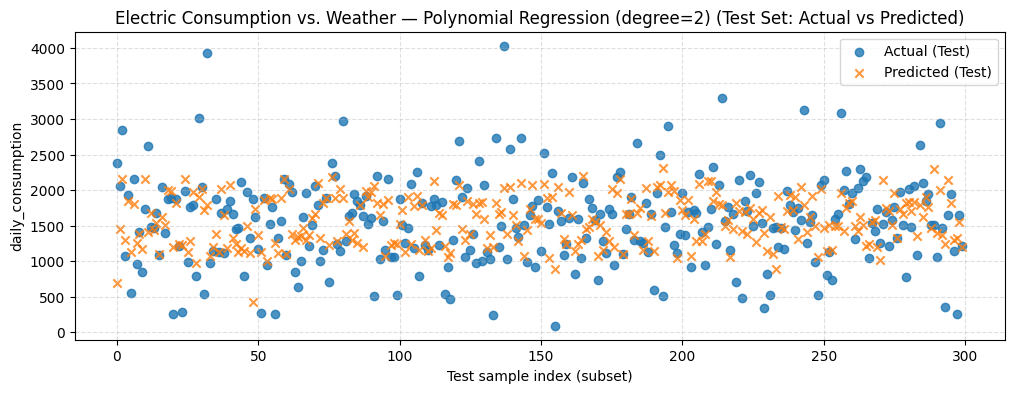


Scenario: Electric Consumption vs. Weather
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1405.7630 (+509.9634) * AWND (-140.8094) * AWND^2 (+67.4216) * TMAX (-63.7983) * TMIN (+25.0565) * TMAX TMIN (-20.2281) * AWND TMIN (-13.9648) * TMIN^2 (-13.1044) * TMAX^2 (+9.3010) * PRCP (+7.8406) * AWND^3 (-4.9294) * AWND PRCP (+3.8559) * AWND^2 TMAX (+3.4853) * AWND TMAX TMIN (+2.2711) * AWND TMAX (-1.8669) * TMAX^2 TMIN
(Showing top 15 terms out of 34 total terms.)


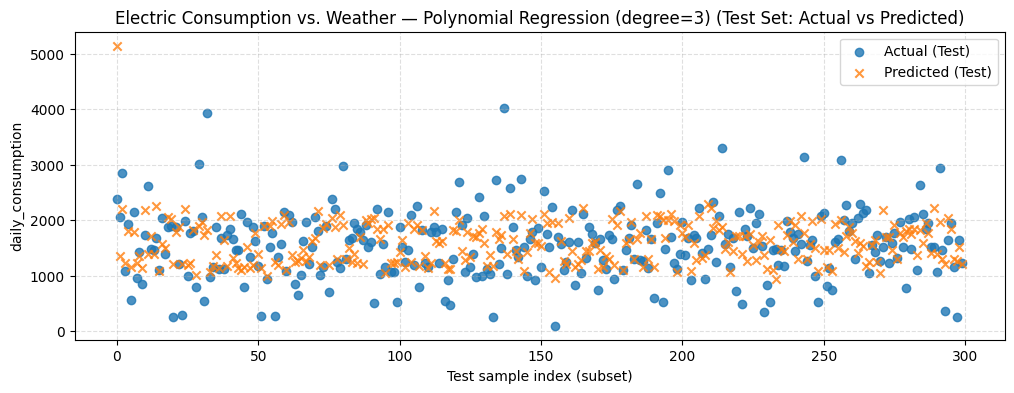


Scenario: Electric Consumption vs. Weather
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1437.2413 (-416.4509) * AWND (-386.5721) * TMIN (+312.1157) * TMAX (+245.1996) * AWND^2 (+175.5947) * TMAX TMIN (+144.1717) * AWND TMAX (-110.1963) * AWND TMIN (-89.7729) * TMIN^2 (-83.0902) * AWND PRCP (-82.3475) * TMAX^2 (-63.0753) * AWND^2 TMAX (+58.6639) * AWND^2 TMIN (-41.9050) * AWND^3 (+26.1746) * AWND^2 PRCP (-25.1428) * AWND TMAX TMIN
(Showing top 15 terms out of 69 total terms.)


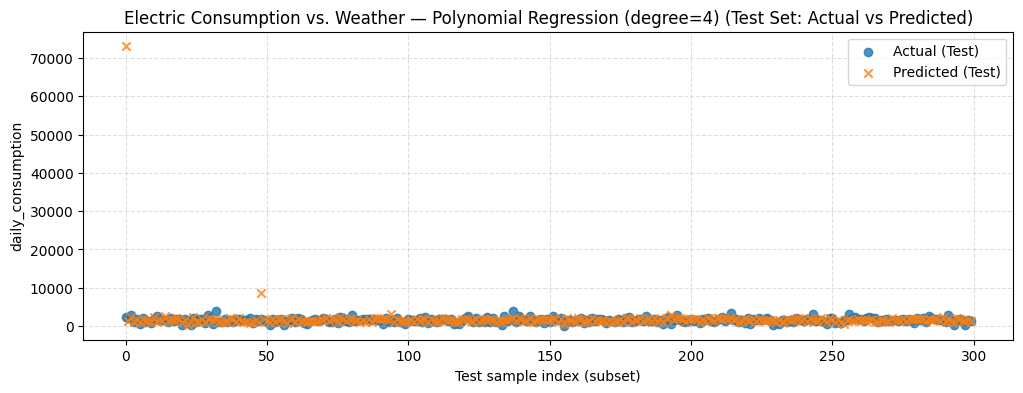

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Electric Consumption vs. Weather,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333,992,426
1,Electric Consumption vs. Weather,Polynomial Regression (degree=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163,992,426
2,Electric Consumption vs. Weather,Polynomial Regression (degree=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922,992,426
3,Electric Consumption vs. Weather,Polynomial Regression (degree=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844,992,426


In [14]:
results = run_models_and_evaluate(
    df,
    scenario_name="Electric Consumption vs. Weather",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results)

# Discussion

The linear model has the best result, with the lowest MSE (2.48e5), MAE(379), and highest R^2(0.299), which indicates that daily consumption has a weak linear relationship with weather. The polynomial fits have a better fit when it comes to the training data, but actually perform worse when tested (using the same metrics of MSE, MAE, R^2). This suggests that there is overfitting occuring, which results in more inaccurate test results. This effect is especially prevalent with the 4th degree model, where the R^2 value is -33, showing a significant case of overfitting. The overall poor test performance across all models suggests that weather alone is insufficient to accurately predict electricity consumption, even when multiple weather variables are used. There may be other factors such as the season, or other behavioral factors that are not captured by this dataset. This conclusion is directly supported by the low R^2 values across all the models.